# Multiple Variable Wavelet Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from scipy import signal
import pywt

from crypr.util import get_project_path
from crypr.build import make_features, data_to_supervised, make_3d
from crypr.transformers import PassthroughTransformer, HaarSmoothTransformer

In [2]:
SYM = 'BTC'
TARGET = 'close'
Tx = 72
Ty = 1
TEST_SIZE = 0.05

data_path = join(get_project_path(), 'data', 'raw', SYM + '.csv')
data = pd.read_csv(data_path, index_col=0)

"""
Train Test Split.
"""
data_train, data_test = train_test_split(data, test_size=TEST_SIZE, shuffle=False)
data_train = data_train.dropna()
data_test = data_test.dropna().iloc[:-1]

p(data_train.shape, data_test.shape)
data_test.head()

(5699, 8) (299, 8)


,volumeto,volumefrom,open,high,close,low,time,timestamp
5699,6870278.96,1667.10,4136.84,4136.84,4107.66,4107.66,1553914800,2019-03-30 04:00:00
5700,14908933.29,3647.41,4107.66,4108.47,4098.41,4066.87,1553918400,2019-03-30 05:00:00
5701,3949508.61,962.35,4098.41,4111.00,4111.00,4095.26,1553922000,2019-03-30 06:00:00
5702,2399500.24,583.69,4111.00,4116.59,4110.90,4108.02,1553925600,2019-03-30 07:00:00
5703,3269364.63,793.65,4110.90,4111.44,4108.34,4103.51,1553929200,2019-03-30 08:00:00


In [3]:
"""
Get features.
"""
feature_data_train = make_features(input_df=data_train, target_col='close', ma_cols=['volumeto', 'volumefrom'], ma_lags=[3, 6, 12])
feature_data_test = make_features(input_df=data_test, target_col='close', ma_cols=['volumeto', 'volumefrom'], ma_lags=[3, 6, 12])

feature_data_train.dropna(inplace=True)
feature_data_test.dropna(inplace=True)

feature_data_test.head()

,ma3__volumeto,ma3__volumefrom,ma6__volumeto,ma6__volumefrom,ma12__volumeto,ma12__volumefrom,target__close
0,2.520510e+06,613.616667,2.529997e+06,616.085000,4.172013e+06,1016.600833,-0.023656
1,2.971374e+06,724.746667,2.676202e+06,651.725000,3.891521e+06,949.022500,-0.195882
2,4.742395e+06,1154.836667,3.581690e+06,871.693333,3.326678e+06,809.770000,0.347072
3,4.923989e+06,1199.033333,3.722250e+06,906.325000,3.258950e+06,793.287500,-0.195832
4,4.355702e+06,1059.930000,3.663538e+06,892.338333,3.208951e+06,781.217500,0.187674


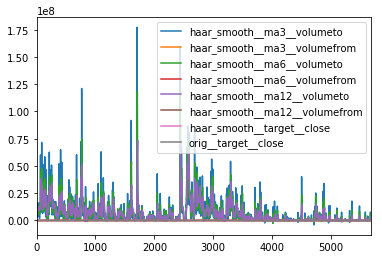

In [4]:
"""
Apply DWT Smooth.
"""
transformers = [
    ('haar_smooth', HaarSmoothTransformer(.05), list(feature_data_train.columns)),
    ('orig', PassthroughTransformer(), ['target__close']),
]

ct = ColumnTransformer(transformers=transformers, n_jobs=-1)

smooth_arr_train = ct.fit_transform(feature_data_train)
smooth_data_train = pd.DataFrame(smooth_arr_train, columns=ct.get_feature_names())

smooth_arr_test = ct.fit_transform(feature_data_test)
smooth_data_test = pd.DataFrame(smooth_arr_test, columns=ct.get_feature_names())

smooth_data_train.plot(); plt.show()

In [5]:
"""
Make time-series data.
"""
X_train, y_train = data_to_supervised(input_df=smooth_data_train, target_ix=-1, Tx=Tx, Ty=Ty)
X_test, y_test = data_to_supervised(input_df=smooth_data_test, target_ix=-1, Tx=Tx, Ty=Ty)
p(X_train.head())
p(y_train.head())

"""
Reshape the data into 3d array.
"""
X_train = make_3d(X_train, tx=Tx, num_channels=len(list(feature_data_train.columns)) + 1)
X_test = make_3d(X_test, tx=Tx, num_channels=len(list(feature_data_test.columns)) + 1)

X_train.view()

      var1(t-72)  var2(t-72)    var3(t-72)   var4(t-72)    var5(t-72)  \
72  9.216695e+06  832.594840  1.022283e+07  1095.199159  1.225794e+07   
73  7.463667e+06  756.389380  1.022283e+07  1095.199159  1.148445e+07   
74  3.556348e+06  101.350443  9.587689e+06   955.079993  8.786431e+06   
75  3.556348e+06  101.350443  8.714282e+06   931.889991  8.786431e+06   
76  3.098327e+06   38.962110  4.814071e+06   318.176659  8.327318e+06   

     var6(t-72)  var7(t-72)  var8(t-72)    var1(t-71)  var2(t-71)  ...  \
72  1384.764081    0.255384    0.844051  7.463667e+06  756.389380  ...   
73  1327.479642   -0.255384   -0.262833  3.556348e+06  101.350443  ...   
74   915.855611    0.000000   -0.074496  3.556348e+06  101.350443  ...   
75   915.855611    0.000000   -0.230524  3.098327e+06   38.962110  ...   
76   851.361861   -0.147707   -0.284267  3.098327e+06   38.962110  ...   

    var7(t-2)  var8(t-2)     var1(t-1)    var2(t-1)     var3(t-1)  \
72  -0.228598  -0.386556  2.949626e+07  4099.91

array([[[ 9.21669469e+06,  8.32594840e+02,  1.02228324e+07, ...,
          1.38476408e+03,  2.55383583e-01,  8.44051158e-01],
        [ 7.46366688e+06,  7.56389380e+02,  1.02228324e+07, ...,
          1.32747964e+03, -2.55383583e-01, -2.62832891e-01],
        [ 3.55634795e+06,  1.01350443e+02,  9.58768922e+06, ...,
          9.15855611e+02,  0.00000000e+00, -7.44963631e-02],
        ...,
        [ 3.19752003e+07,  4.51149605e+03,  4.48987705e+07, ...,
          3.78480825e+03, -1.09089441e+00, -1.68907412e+00],
        [ 2.94962558e+07,  4.09991711e+03,  4.42218416e+07, ...,
          3.96005644e+03, -2.28598467e-01, -3.86556020e-01],
        [ 2.94962558e+07,  4.09991711e+03,  3.85732896e+07, ...,
          3.96005644e+03,  2.28598467e-01,  6.66757795e-01]],

       [[ 7.46366688e+06,  7.56389380e+02,  1.02228324e+07, ...,
          1.32747964e+03, -2.55383583e-01, -2.62832891e-01],
        [ 3.55634795e+06,  1.01350443e+02,  9.58768922e+06, ...,
          9.15855611e+02,  0.00000000e

In [6]:
"""
Save data.
"""
output_dir = join(get_project_path(), 'data', 'processed')

np.save(arr=X_train, file=join(output_dir, 'X_train_multiple_smooth_{}'.format(SYM)))
np.save(arr=X_test, file=join(output_dir, 'X_test_multiple_smooth_{}'.format(SYM)))
np.save(arr=y_train, file=join(output_dir, 'y_train_multiple_smooth_{}'.format(SYM)))
np.save(arr=y_test, file=join(output_dir, 'y_test_multiple_smooth_{}'.format(SYM)))